# Creation of a neural network

In this task, a fully connected neural network is created using tensorflow's low-level mechanisms.

The architecture of the neural network is presented in the following figure. As you can see, it has one input layer, two hidden layers, and an output layer. The sigmoid will be used as the activation function in the hidden layers. On the output layer we use softmax.

## Neural network architecture

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## About the MNIST dataset

This neural network will be studied on the MNIST dataset. This dataset is a large number of images of handwritten digits of size $28 \times 28$ pixels. Each pixel takes a value from 0 to 255.

The dataset will be divided into training and test samples. At the same time, all images are normalized so that the pixel value is between 0 and 1 by dividing the brightness of each pixel by 255.

In addition, the architecture of the neural network expects an input vector. In our case, each sample object is a matrix. What to do? In this task, the matrix $28 \times 28$ will be "stretched", thus obtaining a vector consisting of 784 elements.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

More information about the dataset can be found [here](http://yann.lecun.com/exdb/mnist/).

Imports

In [32]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
from keras.datasets import mnist

Constants

In [33]:
num_classes = 10 # the total number of classes, in our case these are numbers from 0 to 9
num_features = 784 # the number of attributes of the input vector is 28 * 28 = 784

learning_rate = 0.001 # learning speed of the neural network
training_steps = 20000 # the maximum number of epochs
batch_size = 256 # network weights will be calculated not on the entire sample, but on its random subset of batch_size elements
display_step = 100 # every 100 iterations the current value of the loss function and accuracy will be displayed

n_hidden_1 = 128 # the number of neurons of the 1st layer
n_hidden_2 = 256 # the number of neurons of the 2nd layer

DataSet

In [34]:
# Loading the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Converting integer pixels to float32 type
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Converting 28x28 pixel matrices into a vector of 784 elements
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Normalizing pixel values
x_train, x_test = x_train / 255., x_test / 255.

# Mixing the training data
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

Creating a neural network

In [35]:
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)


class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # The first layer, which consists of 128 neurons
    self.layer1 = DenseLayer(num_features, n_hidden_1, name='layer1')
    # The second layer, which consists of 256 neurons
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2, name='layer2')
    # Output layer
    self.out_layer = DenseLayer(n_hidden_2, num_classes, name='out_layer')

  def __call__(self, x):
    # Data transmission through the first two layers and the output layer with softmax activation function
    x = self.layer1(x, activation=0)
    x = self.layer2(x, activation=0)
    x = self.out_layer(x, activation=1)

    return x

Cross-entropy as the error function

In [36]:
def cross_entropy(y_pred, y_true):
    # The label encoding into one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction value to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Calculation of cross-entropy.
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

Accuracy as a quality metric

In [37]:
def accuracy(y_pred, y_true):
    # Comparing the predicted values with the true labels
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    # Calculating the average accuracy using convolution
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

The learning function of the neural network

In [38]:
def train(neural_net, input_x, output_y):
  # To adjust the weights of the network, stochastic gradient descent is used
  optimizer = tf.optimizers.SGD(learning_rate)

  # Activation of automatic differentiation
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Getting a list of optimized parameters
    trainable_variables = neural_net.trainable_variables

    # Calculating the value of the gradient based on them
    gradients = g.gradient(loss, trainable_variables)

    # Modifying the parameters
    optimizer.apply_gradients(zip(gradients, trainable_variables))

Creating an instance of a neural network

In [39]:
neural_net = NN(name="mnist")

Network training

In [40]:
loss_history = []  # every 'display_step' of steps saving the current error of the neural network in this list
accuracy_history = [] # every 'display_step' of steps store the current accuracy of the neural network in this list

# A random subset is drawn from the training dataset train_data on which training will take place.
# The 'take' method available for the training dataset is used.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Updating the weights of the neural network
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss)
        accuracy_history.append(acc)
        print(f"Step: {step}, Loss function: {loss}, Accuracy: {acc}")

Step: 100, Loss function: 244.65890502929688, Accuracy: 0.7109375
Step: 200, Loss function: 193.6385955810547, Accuracy: 0.8046875
Step: 300, Loss function: 161.30845642089844, Accuracy: 0.80859375
Step: 400, Loss function: 164.2674560546875, Accuracy: 0.8125
Step: 500, Loss function: 171.88916015625, Accuracy: 0.81640625
Step: 600, Loss function: 146.17465209960938, Accuracy: 0.8046875
Step: 700, Loss function: 88.85125732421875, Accuracy: 0.87890625
Step: 800, Loss function: 123.90691375732422, Accuracy: 0.83984375
Step: 900, Loss function: 122.08164978027344, Accuracy: 0.8671875
Step: 1000, Loss function: 104.20140075683594, Accuracy: 0.890625
Step: 1100, Loss function: 76.48980712890625, Accuracy: 0.89453125
Step: 1200, Loss function: 81.98368835449219, Accuracy: 0.90234375
Step: 1300, Loss function: 84.53919982910156, Accuracy: 0.890625
Step: 1400, Loss function: 102.9722900390625, Accuracy: 0.8828125
Step: 1500, Loss function: 100.76174926757812, Accuracy: 0.90625
Step: 1600, Los

Graphs of the dependence of changes in accuracy and losses on the step (accuracy should increase and losses should decrease)

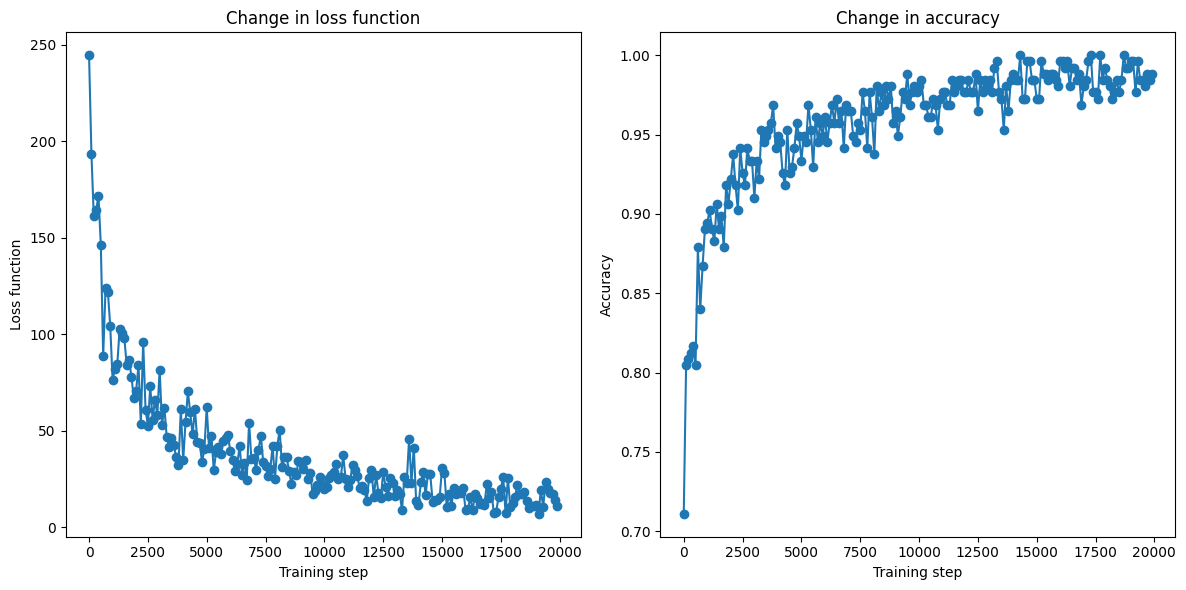

In [41]:
# Graph of the loss function
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, training_steps + 1, display_step), loss_history, marker='o', linestyle='-')
plt.title('Change in loss function')
plt.xlabel('Training step')
plt.ylabel('Loss function')

# Graph of the accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, training_steps + 1, display_step), accuracy_history, marker='o', linestyle='-')
plt.title('Change in accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

Calculation of the accuracy of the trained neural network

In [42]:
# Model testing on test data
test_pred = neural_net(x_test)
print(f"Accuracy on test data: {accuracy(test_pred, y_test)*100:.2f}%")

Accuracy on test data: 93.39%


Testing the trained neural network on 10 random images

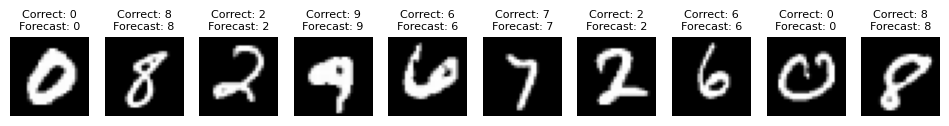

Accuracy on 10 images: 100.00%


In [43]:
# Choosing 10 random images from the test sample
random_indices = random.sample(range(len(x_test)), 10)
test_images = x_test[random_indices]
test_labels = y_test[random_indices]

# Predicting the classes for the selected images
predictions = neural_net(test_images)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

# Display the image and the answer of the neural network next to it
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(test_images[i].reshape((28, 28)), cmap='gray')
    plt.title(f"Correct: {test_labels[i]}\nForecast: {predicted_labels[i]}", fontsize = 8)
    plt.axis('off')

plt.show()

# Comparing the predictions with the correct labels and calculating the accuracy
correct_predictions = (predicted_labels == test_labels)
accuracy = sum(correct_predictions) / len(correct_predictions)
print(f"Accuracy on 10 images: {accuracy * 100:.2f}%")

### Conclusion

Based on the results on the training data, the model performed well, as the accuracy in 20.000 epochs = 0.94. The model handled the test data in line with its accuracy.

Based on the results of training and testing, it is possible to draw conclusions about the quality of the trained network, its effectiveness in solving the task of recognizing handwritten digits, and possible ways of further improvement.